In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt, shap, pandas as pd, numpy as np, tensorflow as tf

In [2]:
shap.initjs()
pd.set_option('display.max_columns', None)

In [26]:
def mean_absolute_percentage_error(y_true, y_pred):
    return tf.abs(tf.reduce_mean((y_true - y_pred) / y_true)) * 100

In [38]:
#df = pd.read_feather('E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/merged-full-25ms-24hr-28-2-24.feather')
#df = pd.read_feather('E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/merged-full-W-Landscape-And-Station-Elevations-25ms-24hr-11-3-24.feather')
#df = pd.read_feather('D:\Skóli\lokaverkefni_vel\data\merged-full-W-Landscape-And-Station-Elevations-25ms-24hr-11-3-24.feather')
#df = pd.read_feather('E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/merged-full-W-Landscape-And-Station-Elevations-25ms-24hr-13-3-24-stripped-with-klst.feather')
#df = pd.read_feather("E:/Skóli/HÍ/Vélaverkfræði Master Hí/Lokaverkefni/Data/merged-full-W-Landscape-And-Station-Elevations-Circle-larger-x2-25ms-24hr-14-3-24.feather")
#df = pd.read_feather('D:/Skóli/lokaverkefni_vel/data/merged-full-W-Landscape-And-Station-Elevations-2-sectors-25ms-24hr-18-3-24-stripped-with-klst.feather')

df = pd.read_feather("E:/Skóli/HÍ/Vélaverkfræði Master Hí/Lokaverkefni/Data/merged-full-W-Landscape-And-Station-Elevations-2-sectors-25ms-24hr-18-3-24-stripped-with-klst.feather")

df = df[df.f < df.fg]
df['gust_factor'] = df.fg / df.f

df_unfolded = df.elevations.apply(pd.Series)

df = pd.concat([df, df_unfolded], axis = 1)

df = df.dropna()
df = df.reset_index(drop = True)

In [39]:
n_elevations = df.columns[-1] + 1
df.iloc[:, -n_elevations:] = df.iloc[:, -n_elevations:].sub(df.station_elevation, axis = 0)

In [40]:
from sklearn.decomposition import PCA

df_landscape_elevation = df.iloc[:, -n_elevations:]

df_landscape_elevation = (df_landscape_elevation - df_landscape_elevation.mean()) / df_landscape_elevation.std()

n_components = 5

pca = PCA(n_components=n_components)
compressed_features = pca.fit_transform(df_landscape_elevation)

compressed_df = pd.DataFrame(data = compressed_features, columns = ['PC' + str(i) for i in range(n_components)])

df  = pd.concat([df, compressed_df], axis = 1)

In [41]:
from math import sqrt, sin, cos, acos, pi

def cornerFromCenterLand(row):
    X, Y, d = row.X, row.Y, row.d
    inlandX, inlandY = 520000, 485000

    len_v1 = sqrt((X-inlandX)**2 + (Y-inlandY)**2)

    v1 = ((X - inlandX)/len_v1, (Y - inlandY)/ len_v1)

    outX, outY = X + cos(d * pi / 180), Y + sin(d * pi / 180)

    len_v2 = sqrt(outX**2 + outY**2)

    v2 = (outX / len_v2, outY / len_v2)

    return acos(np.dot(v1, v2))
    

In [42]:
df['relativeCorner'] = df.apply(cornerFromCenterLand, axis = 1)

In [51]:
y = df.gust_factor
X = df[['Ri_02', 'N_02', 'Ri_01', 'Ri_12', 'N_01', 'N_12', 'ws_15', 'station_elevation', 'relativeCorner'] + ['PC' + str(i) for i in range(n_components)]]

columns = X.columns

X, y = X.values.astype(np.float32), y.values.astype(np.float32)

scaler = StandardScaler()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)


train = pd.DataFrame(X_train, columns = columns)
train['gust_factor'] = y_train

validate = pd.DataFrame(X_val, columns = columns)
validate['gust_factor'] = y_val

test = pd.DataFrame(X_test, columns = columns)
test['gust_factor'] = y_test

In [52]:
X_shapley = pd.DataFrame(X, columns = columns)

X_shapley

,Ri_02,N_02,Ri_01,Ri_12,N_01,N_12,ws_15,station_elevation,relativeCorner,PC0,PC1,PC2,PC3,PC4
0,18.748764,3.493773e-05,-1.177507,26685.779297,-0.000009,6.778615e-05,8.547100,33.438522,2.732754,22.463312,2.761149,-0.885678,-2.739184,0.804405
1,-5.293901,1.010834e-06,-2.864259,233.822189,-0.000038,1.961899e-06,10.315700,33.438522,2.732754,22.638090,3.057970,-0.753052,-2.713240,0.850448
2,-0.572793,2.315003e-07,-0.329725,0.959123,-0.000027,4.492563e-07,14.070700,33.438522,2.732755,22.545942,3.751601,-0.369128,-2.014236,0.649156
3,-0.834968,1.847719e-06,-0.551073,2.586584,-0.000055,3.586924e-06,15.494100,33.438522,2.732754,22.709574,3.340035,-0.576344,-2.516097,0.798412
4,0.123812,1.737870e-05,-0.261465,19.309135,-0.000028,3.372585e-05,14.274100,33.438522,2.732754,22.662458,3.192364,-0.670980,-2.618812,0.841577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,-63.992447,8.434873e-06,-7.538465,4.194781,-0.000111,1.638547e-05,10.655400,19.654911,0.554137,1.584966,0.067799,-0.005859,0.065996,0.002718
10353,0.117238,4.489728e-05,-0.042580,1.078334,-0.000026,8.712778e-05,25.469801,19.654911,0.554136,1.584966,0.067799,-0.005859,0.065996,0.002718
10354,0.149592,2.092498e-05,-0.110178,12.661773,-0.000023,4.060586e-05,19.372000,19.654911,0.554137,1.584966,0.067799,-0.005859,0.065996,0.002718
10355,-0.274952,1.391812e-05,-0.264139,1.104732,-0.000128,2.704246e-05,23.527800,19.654911,0.554136,1.584966,0.067799,-0.005859,0.065996,0.002718


In [54]:
from tensorflow.keras.regularizers import l2

n_units = 512
n_epochs = 500
batch_size = 128
penalty = 0.1

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=l2(penalty), input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=l2(penalty)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=l2(penalty)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=l2(penalty)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=l2(penalty)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(units=1, activation='linear')
])

In [55]:
model.compile(optimizer='adam', loss=mean_absolute_percentage_error)
# Train the model
model.fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data = (X_val, y_val))

Epoch 1/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 265.9660 - val_loss: 237.7455
Epoch 2/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 208.7167 - val_loss: 327.5816
Epoch 3/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 194.9733 - val_loss: 233.7436
Epoch 4/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 181.0858 - val_loss: 187.3649
Epoch 5/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 170.5174 - val_loss: 246.2603
Epoch 6/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 155.9146 - val_loss: 256.4558
Epoch 7/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 141.4420 - val_loss: 165.4268
Epoch 8/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 128.1412 - val_loss: 114.8291
Epoch 9/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 113.9084 - val_loss: 105.7135
Epoch 10/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 104.2757 - val_loss: 94.3669
Epoch 11/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 94.1079 - val_loss: 105.6215
Epoch 12/5

In [56]:
import shap

background_data = shap.maskers.Independent(X_shapley)

explainer = shap.Explainer(model.predict, background_data)

#shap_values = explainer.shap_values(X_shapley[:100])

shap_values = explainer(X_shapley)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━

PermutationExplainer explainer:   0%|          | 2/10357 [00:00<?, ?it/s]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 4/10357 [00:17<8:16:26,  2.88s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 5/10357 [00:23<11:41:59,  4.07s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 6/10357 [00:28<13:27:19,  4.68s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 7/10357 [00:34<14:50:43,  5.16s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 8/10357 [00:40<15:26:19,  5.37s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 9/10357 [00:46<15:49:30,  5.51s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 10/10357 [00:52<16:04:41,  5.59s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 11/10357 [00:58<16:13:15,  5.64s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 12/10357 [01:03<16:28:24,  5.73s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 13/10357 [01:09<16:39:18,  5.80s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 14/10357 [01:15<16:30:09,  5.74s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 15/10357 [01:21<16:39:19,  5.80s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 16/10357 [01:27<16:31:46,  5.75s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 17/10357 [01:33<16:50:25,  5.86s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 18/10357 [01:38<16:42:57,  5.82s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 19/10357 [01:44<16:43:55,  5.83s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 20/10357 [01:50<16:44:37,  5.83s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 21/10357 [01:56<16:57:46,  5.91s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 22/10357 [02:02<16:57:36,  5.91s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 23/10357 [02:08<16:59:04,  5.92s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 24/10357 [02:14<17:01:48,  5.93s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 25/10357 [02:20<16:55:03,  5.89s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 26/10357 [02:26<16:51:52,  5.88s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:   0%|          | 27/10357 [02:32<16:47:53,  5.85s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 28/10357 [02:37<16:41:49,  5.82s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 29/10357 [02:43<16:41:47,  5.82s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 30/10357 [02:49<16:38:41,  5.80s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 31/10357 [02:55<16:46:14,  5.85s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 32/10357 [03:01<16:52:53,  5.89s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 33/10357 [03:07<16:56:05,  5.91s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 34/10357 [03:13<17:03:56,  5.95s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 35/10357 [03:19<17:17:46,  6.03s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 36/10357 [03:25<17:09:15,  5.98s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 37/10357 [03:31<17:07:48,  5.98s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 38/10357 [03:37<16:56:10,  5.91s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 39/10357 [03:43<17:01:01,  5.94s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 40/10357 [03:48<16:57:41,  5.92s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 41/10357 [03:54<16:53:19,  5.89s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 42/10357 [04:00<16:53:48,  5.90s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 43/10357 [04:06<16:52:25,  5.89s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 44/10357 [04:12<16:53:05,  5.89s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 45/10357 [04:18<16:54:23,  5.90s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 46/10357 [04:24<16:58:00,  5.92s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   0%|          | 47/10357 [04:30<16:46:29,  5.86s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 48/10357 [04:36<17:03:36,  5.96s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 49/10357 [04:42<16:57:38,  5.92s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:   0%|          | 50/10357 [04:47<16:55:40,  5.91s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   0%|          | 51/10357 [04:53<16:56:24,  5.92s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 52/10357 [04:59<16:57:01,  5.92s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 53/10357 [05:05<17:00:04,  5.94s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 54/10357 [05:11<17:02:29,  5.95s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 55/10357 [05:17<16:59:50,  5.94s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 56/10357 [05:23<17:01:23,  5.95s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 57/10357 [05:29<16:54:15,  5.91s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 58/10357 [05:35<16:53:22,  5.90s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 59/10357 [05:41<16:59:49,  5.94s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 60/10357 [05:47<16:55:42,  5.92s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 61/10357 [05:53<16:51:05,  5.89s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 62/10357 [05:58<16:48:38,  5.88s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 63/10357 [06:04<16:48:15,  5.88s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 64/10357 [06:11<17:09:20,  6.00s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 65/10357 [06:16<17:01:38,  5.96s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 66/10357 [06:22<16:59:04,  5.94s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 67/10357 [06:28<17:00:55,  5.95s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 68/10357 [06:34<17:01:21,  5.96s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 69/10357 [06:40<16:59:22,  5.95s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 70/10357 [06:46<16:56:30,  5.93s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 71/10357 [06:52<16:58:35,  5.94s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 72/10357 [07:01<19:44:39,  6.91s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 73/10357 [07:09<20:08:15,  7.05s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 74/10357 [07:16<20:14:37,  7.09s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 75/10357 [07:24<21:01:12,  7.36s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 76/10357 [07:35<24:08:31,  8.45s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 77/10357 [07:41<22:20:41,  7.83s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 78/10357 [07:47<21:02:09,  7.37s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:   1%|          | 79/10357 [07:54<20:07:48,  7.05s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 80/10357 [08:00<19:33:40,  6.85s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 81/10357 [08:07<19:30:53,  6.84s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:   1%|          | 82/10357 [08:16<21:00:35,  7.36s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 83/10357 [08:24<22:15:11,  7.80s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 84/10357 [08:31<20:57:19,  7.34s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 85/10357 [08:38<20:43:22,  7.26s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 86/10357 [08:47<22:15:26,  7.80s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 87/10357 [08:54<21:56:54,  7.69s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 88/10357 [09:00<20:38:14,  7.23s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 89/10357 [09:07<19:50:19,  6.96s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 90/10357 [09:15<20:53:01,  7.32s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 91/10357 [09:23<21:11:35,  7.43s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 92/10357 [09:29<20:03:10,  7.03s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 93/10357 [09:35<19:09:59,  6.72s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 94/10357 [09:41<18:40:07,  6.55s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 95/10357 [09:48<18:53:57,  6.63s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 96/10357 [09:55<19:21:55,  6.79s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 97/10357 [10:01<19:03:46,  6.69s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 98/10357 [10:08<18:49:18,  6.60s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 99/10357 [10:14<18:39:34,  6.55s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 100/10357 [10:21<18:46:47,  6.59s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 101/10357 [10:27<18:27:39,  6.48s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 102/10357 [10:33<18:24:43,  6.46s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 103/10357 [10:40<18:06:34,  6.36s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 104/10357 [10:46<17:51:14,  6.27s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 105/10357 [10:51<17:31:55,  6.16s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 106/10357 [10:57<17:21:08,  6.09s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 107/10357 [11:03<17:15:39,  6.06s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 108/10357 [11:09<17:14:25,  6.06s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 109/10357 [11:16<17:13:28,  6.05s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 110/10357 [11:22<17:11:12,  6.04s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 111/10357 [11:28<17:13:35,  6.05s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 112/10357 [11:34<17:12:57,  6.05s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 113/10357 [11:41<18:14:36,  6.41s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 114/10357 [11:47<18:13:00,  6.40s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:   1%|          | 115/10357 [11:54<18:28:22,  6.49s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 116/10357 [12:02<19:26:44,  6.84s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 117/10357 [12:09<19:54:35,  7.00s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 118/10357 [12:17<20:33:56,  7.23s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 119/10357 [12:24<20:38:07,  7.26s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 120/10357 [12:30<19:40:33,  6.92s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 121/10357 [12:38<20:09:30,  7.09s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 122/10357 [12:44<19:03:07,  6.70s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   1%|          | 123/10357 [12:50<18:40:48,  6.57s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 124/10357 [12:56<18:21:33,  6.46s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 125/10357 [13:02<18:08:46,  6.38s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

In [13]:
from matplotlib import pyplot as plt

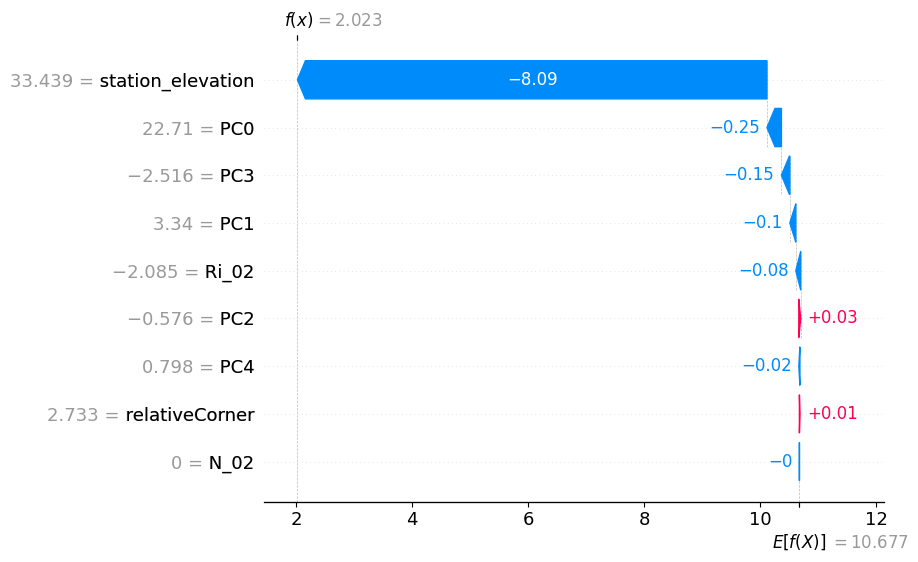

In [ ]:
shap.plots.waterfall(shap_values[5000], max_display=20, show = False)

#plt.savefig("../../visualization/shap_waterfall_nn_256_example100.png", bbox_inches = 'tight', dpi = 1000)

plt.show()


In [ ]:
mape = model.evaluate(X_test, y_test)
print(f'MAPE: {mape:.2f}%')


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8160 
MAPE: 8.67%


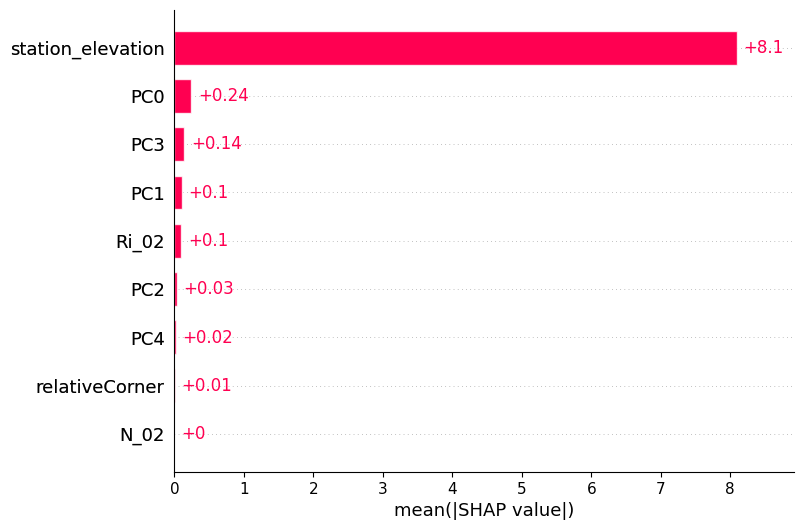

In [ ]:
shap.plots.bar(shap_values, max_display=20, show=False)

#plt.savefig("../../visualization/shap_bar_nn_256_example100.png", bbox_inches = 'tight', dpi = 1000)

plt.show()